<a href="https://colab.research.google.com/github/zhichunqi/Deep-Learning-HW/blob/master/Yelp_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
import sys
# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Deep Learning/'

#Loading the data
import pandas as pd

# Load the raw training data

import pandas as pd
filepath_dict = {'yelp':   abspath_curr + '/Sentiment_Analysis/yelp_labelled.txt'}
df_list = []

for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df_list.append(df)

reviews_df = pd.concat(df_list)
reviews_df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,sentence,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [21]:
reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)

# Clean data( Modification)

In [22]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["sentence_clean"] = reviews_df["sentence"].apply(lambda x: clean_text(x))

#Feature Engineering(Modification)

In [23]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["sentence"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [24]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["sentence"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["sentence"].apply(lambda x: len(x.split(" ")))

In [25]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["sentence_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["sentence_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [26]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["sentence_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

#Exploratory data analysis

In [27]:
# show label distribution
reviews_df["label"].value_counts(normalize = True)

1    0.56
0    0.44
Name: label, dtype: float64

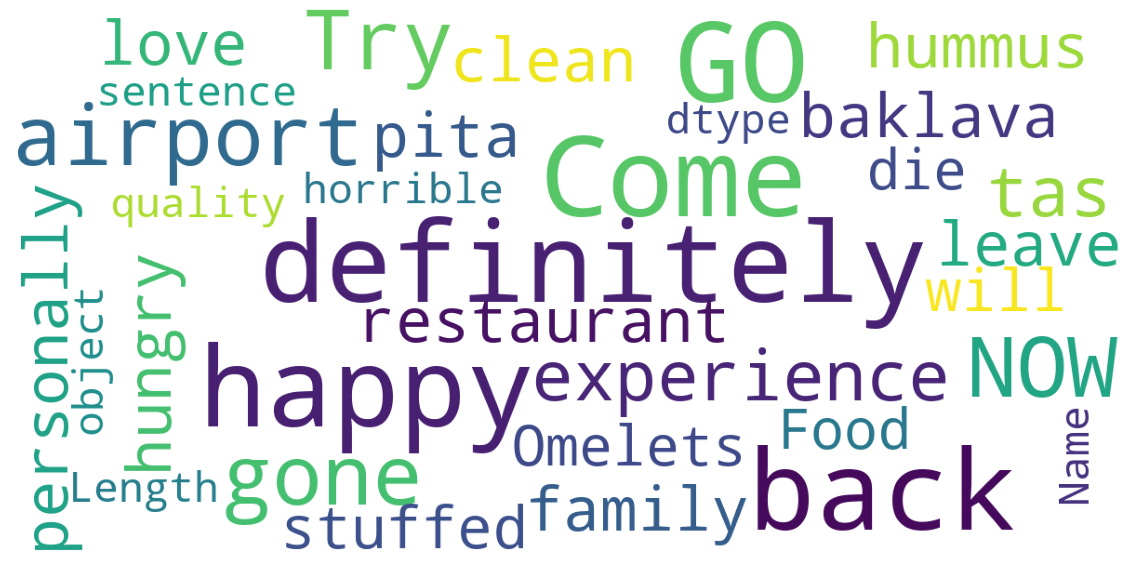

In [28]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["sentence"])

In [29]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["sentence", "pos"]].head(10)

,sentence,pos
499,Waitress was sweet and funny.,0.663
662,The owners are super friendly and the staff is...,0.598
678,It's a great place and I highly recommend it.,0.580
346,"This place is like Chipotle, but BETTER.",0.573
23,I could care less... The interior is just beau...,0.542
578,The staff are also very friendly and efficient.,0.522
299,The food was excellent and service was very good.,0.496
764,"I'm so happy to be here!!!""",0.493
626,Best of luck to the rude and non-customer serv...,0.471
66,Always a great time at Dos Gringos!,0.468


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


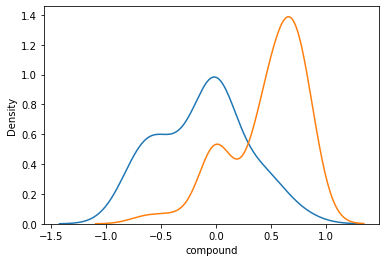

In [30]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['label'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)# plot sentiment distribution for positive and negative reviews



#Random Forest(Modification)

In [31]:
# feature selection
label = "label"
ignore_cols = [label, "sentence", "sentence_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

In [32]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
3,compound,0.152421
2,pos,0.134690
0,neg,0.094190
10,doc2vec_vector_4,0.089808
4,nb_chars,0.089122
7,doc2vec_vector_1,0.080083
6,doc2vec_vector_0,0.074025
1,neu,0.072689
8,doc2vec_vector_2,0.063661
9,doc2vec_vector_3,0.062875


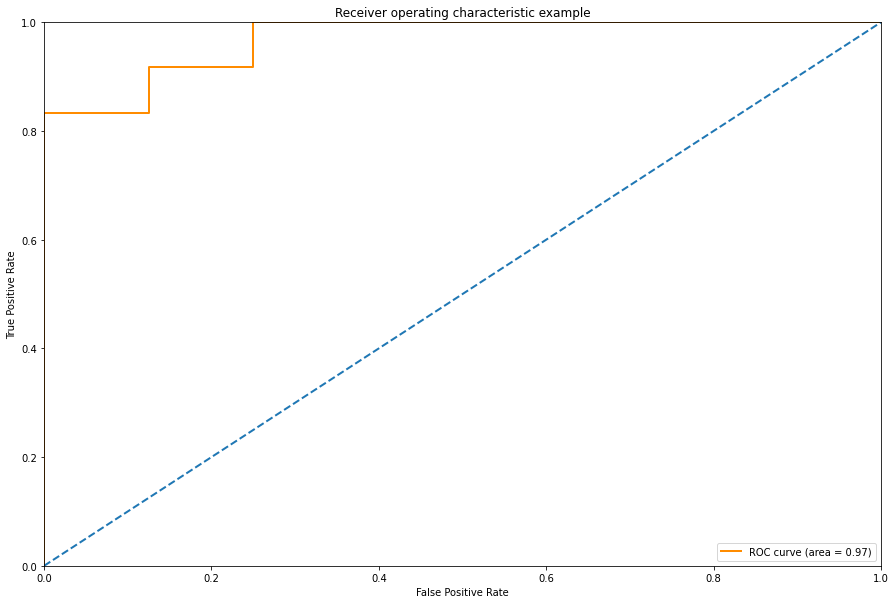

In [33]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.98')

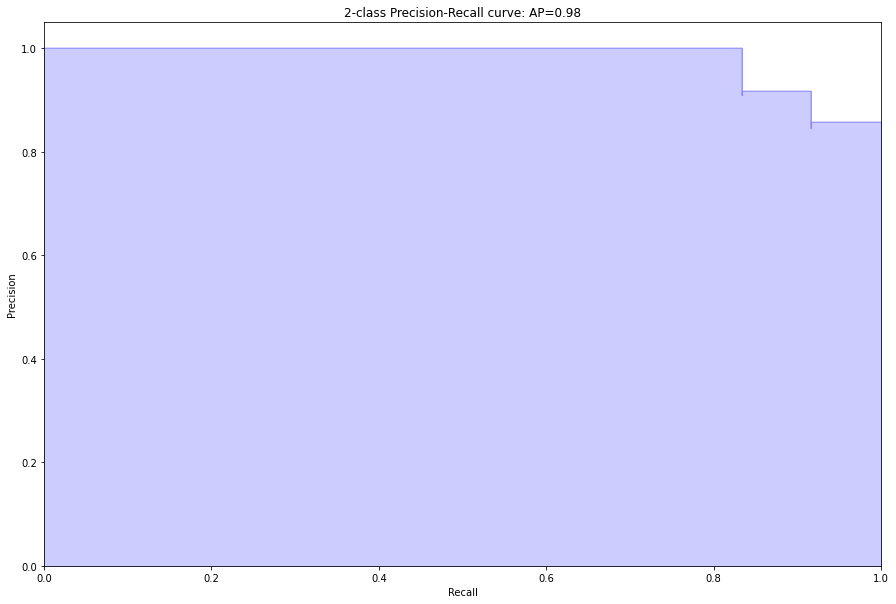

In [34]:
# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve
from inspect import signature

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploratory Data

In [40]:
    # Add another column filled with the source name
    df_list.append(df)

reviews_df = pd.concat(df_list)
reviews_df.head()

,sentence,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


# Defining a Baseline Model

Overfitting is when a model is trained too well on the training data. You want to avoid overfitting, as this would mean that the model mostly just memorized the training data. This would account for a large accuracy with the training data but a low accuracy in the testing data.

We start by taking the Yelp data set which we extract from our concatenated data set. From there, we take the sentences and labels. The .values returns a NumPy array instead of a Pandas Series object which is in this context easier to work with:

In [42]:
from sklearn.model_selection import train_test_split



sentences = reviews_df['sentence'].values
y = reviews_df['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentences, y, test_size=0.25, random_state=1000)

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<2250x2018 sparse matrix of type '<class 'numpy.int64'>'
	with 21998 stored elements in Compressed Sparse Row format>

In [48]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.972


# A Primer on (Deep) Neural Networks

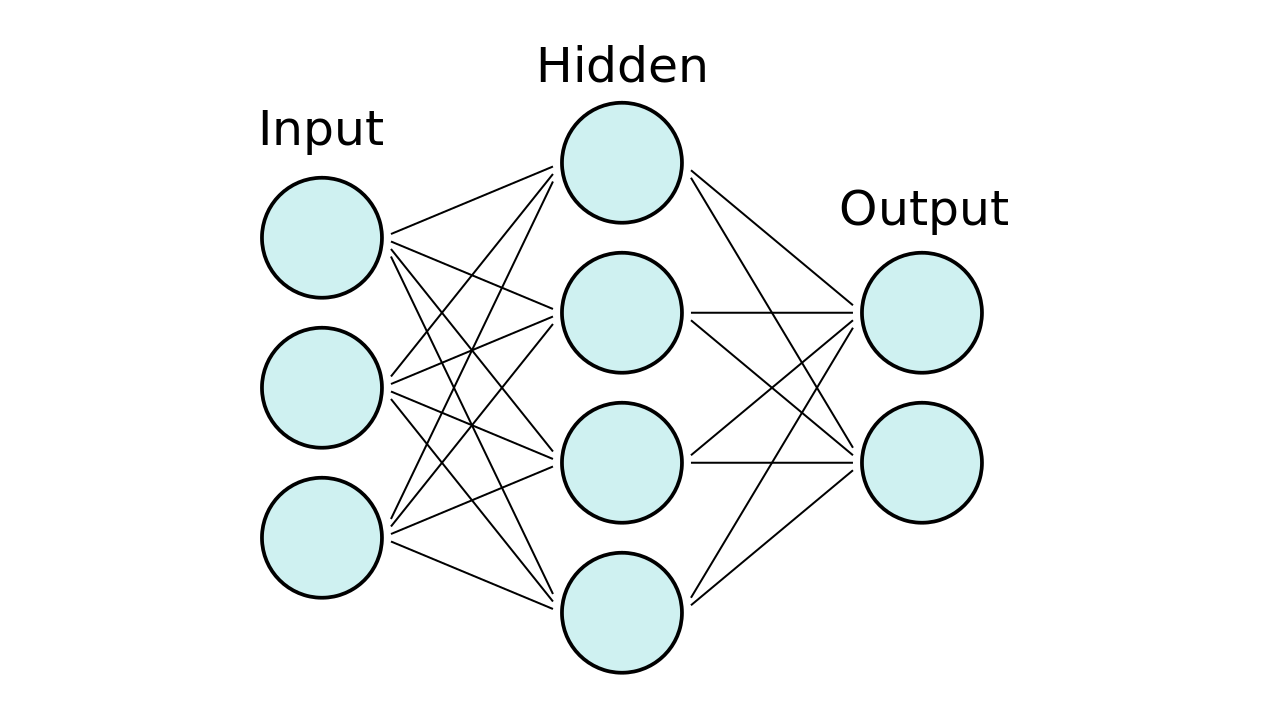

# First Keras Model

In [49]:
pip install keras

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/cli/base_command.py", line 153, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py", line 438, in run
    self._warn_about_conflicts(to_install)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py", line 568, in _warn_about_conflicts
    package_set, _dep_info = check_install_conflicts(to_install)
  File "/usr/local/lib/python3.6/

In [56]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [57]:
model.compile(loss='binary_crossentropy', 
            optimizer='adam', 
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                20190     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________


In [58]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/100
225/225 [==============================] - 0s 2ms/step - loss: 0.6104 - accuracy: 0.7516 - val_loss: 0.4896 - val_accuracy: 0.8720
Epoch 2/100
225/225 [==============================] - 0s 1ms/step - loss: 0.3477 - accuracy: 0.9338 - val_loss: 0.2960 - val_accuracy: 0.9347
Epoch 3/100
225/225 [==============================] - 0s 1ms/step - loss: 0.1894 - accuracy: 0.9760 - val_loss: 0.2011 - val_accuracy: 0.9533
Epoch 4/100
225/225 [==============================] - 0s 1ms/step - loss: 0.1157 - accuracy: 0.9862 - val_loss: 0.1546 - val_accuracy: 0.9707
Epoch 5/100
225/225 [==============================] - 0s 1ms/step - loss: 0.0759 - accuracy: 0.9960 - val_loss: 0.1278 - val_accuracy: 0.9760
Epoch 6/100
225/225 [==============================] - 0s 1ms/step - loss: 0.0529 - accuracy: 0.9973 - val_loss: 0.1109 - val_accuracy: 0.9733
Epoch 7/100
225/225 [==============================] - 0s 2ms/step - loss: 0.0382 - accuracy: 0.9982 - val_loss: 0.1014 - val_accuracy: 0.9747

In [59]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 1.0000
Testing Accuracy:  0.9840


In [60]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()



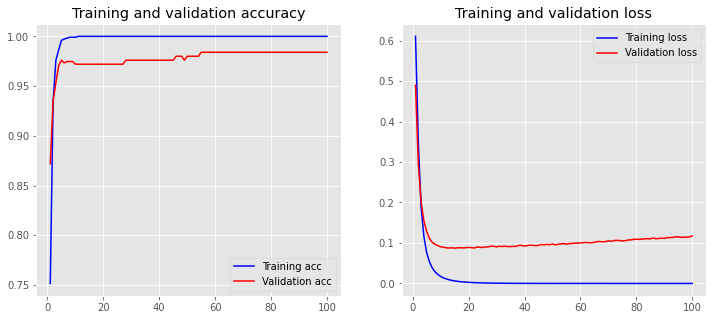

In [61]:
plot_history(history)

# Word Embedding

In [ ]:
cities = ['London', 'Berlin', 'Berlin', 'New York', 'London']
cities

['London', 'Berlin', 'Berlin', 'New York', 'London']

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
city_labels = encoder.fit_transform(cities)
city_labels

array([1, 0, 0, 2, 1])

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
city_labels = city_labels.reshape((5, 1))
encoder.fit_transform(city_labels)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [62]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

Not a single employee came out to see if we were OK or even needed a water refill once they finally served us our food.
[12, 5, 523, 837, 89, 57, 6, 274, 50, 18, 28, 405, 97, 93, 524, 5, 406, 525, 237, 35, 627, 335, 85, 38, 10]


In [63]:
for word in ['the', 'all','great','worse']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 39
great: 22
worse: 381


In [64]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[191 158  19  80 273  17   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


# Keras Embedding Layer

In [65]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           102700    
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 152,721
Trainable params: 152,721
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.9840


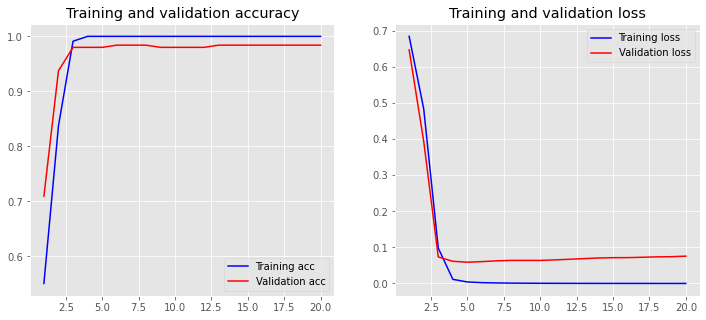

In [66]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [67]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           102700    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 103,221
Trainable params: 103,221
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.9840


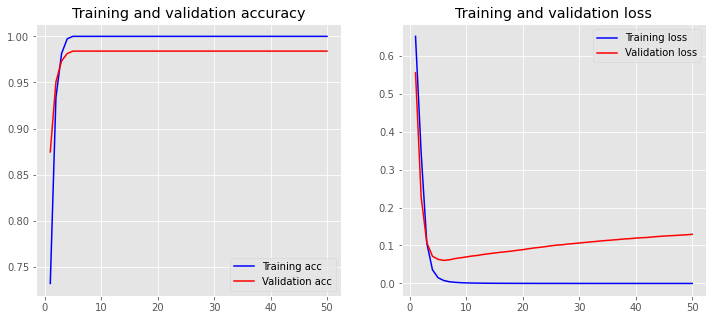

In [68]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

# Using Pretrained Word Embeddings

In [69]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('/content/drive/My Drive/glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim)

In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9507727532913566

In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 100, 50)           87350     
_________________________________________________________________
global_max_pooling1d_19 (Glo (None, 50)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 11        
Total params: 87,871
Trainable params: 521
Non-trainable params: 87,350
_________________________________________________________________


Training Accuracy: 0.7880
Testing Accuracy:  0.6960


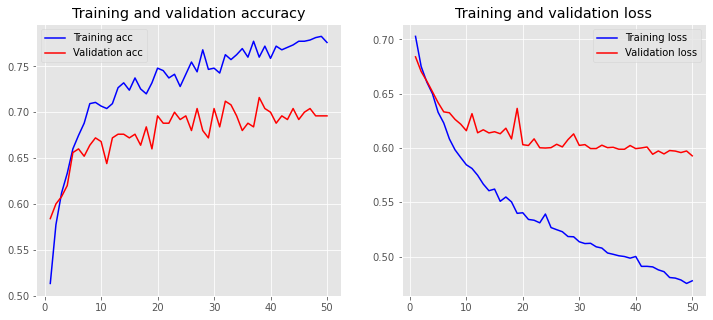

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 100, 50)           87350     
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 50)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 11        
Total params: 87,871
Trainable params: 87,871
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7800


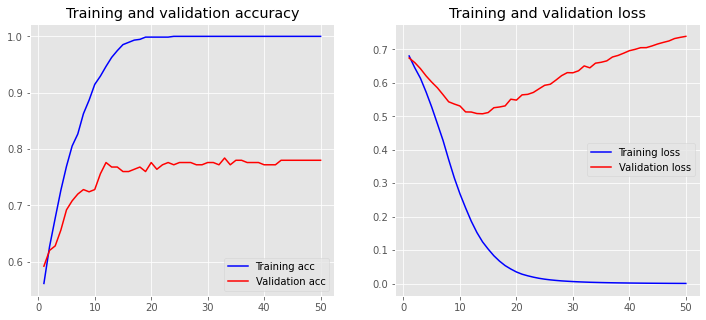

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

# Convolutional Neural Networks (CNN)

In [ ]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 100, 100)          174700    
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_21 (Glo (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 11        
Total params: 240,129
Trainable params: 240,129
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.8160


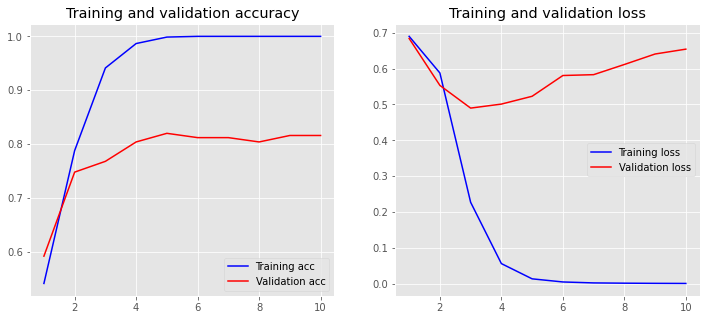

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

# Build a neural network with LSTM(Modification)

In [ ]:
from keras.layers.convolutional import Conv1D 

In [ ]:
from keras.layers import GlobalMaxPooling1D

In [ ]:
from keras.layers.recurrent import LSTM

In [ ]:
from keras.layers.core import Dense, SpatialDropout1D
from keras.layers.recurrent import LSTM

In [ ]:
# RNN (LSTM)
# max_words = 10000
# maxlen = 200

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))

model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_49 (Embedding)     (None, 100, 50)           87350     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 65        
Total params: 116,855
Trainable params: 116,855
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.5067
Testing Accuracy:  0.4800


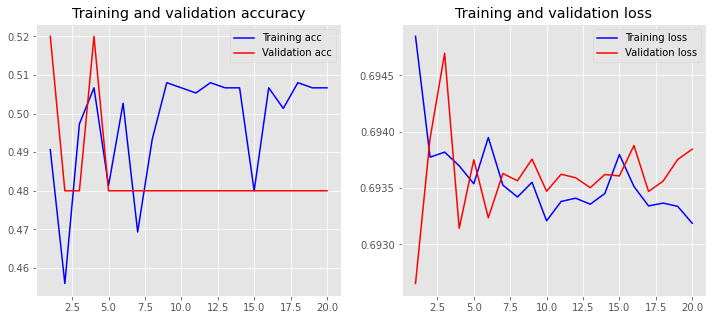

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
model.evaluate(X_test,y_test)

8/8 [==============================] - 0s 15ms/step - loss: 0.6938 - accuracy: 0.4800


[0.693845272064209, 0.47999998927116394]

For the first three epochs, the training accuracy and validation accuract are similar, which means that the patterns or rules network learns on the training generalize well to the validation set. However, after two epochs, the model overfitted the training data, giving higher training accuracy than validation accuracy.

# Build a neural network with an extra 1D CNN on top of LSTM layer(Modification)

In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))

model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))

model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_64 (Embedding)     (None, 100, 50)           87350     
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dense_94 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_95 (Dense)             (None, 2)                 202       
Total params: 158,052
Trainable params: 158,052
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.5067
Testing Accuracy:  0.4800


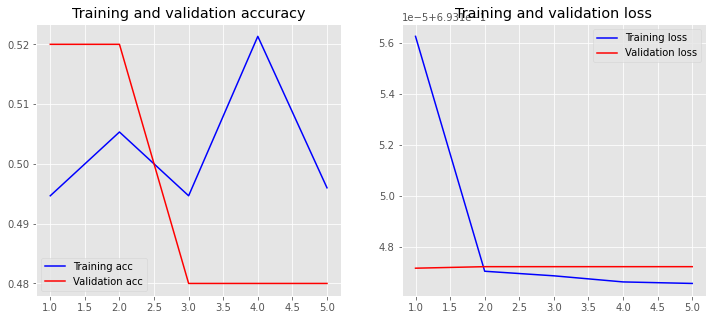

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

# Hyperparameters Optimization

In [74]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [75]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
sentences = reviews_df['sentence'].values
y = reviews_df['label'].values

    # Train-test split
sentences_train, sentences_test, y_train, y_test = train_test_split(
sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
prompt = input(f'finished {source}; write to file and proceed? [y/n]')
if prompt.lower() not in {'y', 'true', 'yes'}:
        break
with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  7.1min finished


finished yelp; write to file and proceed? [y/n]y
